Github repo: https://github.com/luisdi28ms/deep_learning/tree/main/cnn

# Brief description of the problem and data

The problem is to identify metastatic cancer in small image patches taken from larger digital pathology scans. To achieve this, a training set containing each image labeled as positive whenever the center 32x32px region of a patch contains at least one pixel of tumor tissue.

- Objective: The score is evaluated as area under the ROC curve between predicted and observed values. Various convnets model structures will be examined to determine the best performing architecture for this problem.

- Type of Problem: Binary image classification.

- Dataset: Modified version of the PatchCamelyon (PCam) benchmark dataset.

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

[Razuki](https://www.kaggle.com/sgjustino). (2024). CNN Final Modeling. Kaggle. https://www.kaggle.com/code/sgjustino/cnn-final-modeling

**Note:** Razuki's notebook was used as guidance establishing the end-to-end pipeline to then work on enhancing model 2 and submiting the output to the kaggle competition. Learn more clicking the link above.

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [2]:
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [3]:
train_data.info()
print("\n")
print("Count of test observations:",len(os.listdir(test_path)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Count of test observations: 57458


# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data



In a quick note, this is how the image will look on very low resolution (10x10). For the example 10x10 is chosen so the values can be observed easily in matrix form. For modeling a 64x64 is used instead.

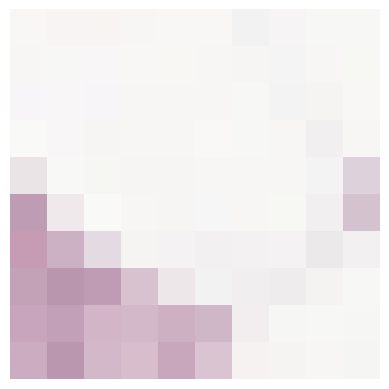

In [4]:
# Locate a single image
image_path = os.path.join(train_path, train_data['id'][0] + '.tif')  
image = Image.open(image_path)

# Resize the image
image = image.resize((10, 10))

# Convert the image to a numpy array
image_matrix = np.array(image)
plt.imshow(image_matrix)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

And this is how the low resolution image is represented in a (10x10x3) matrix.

In [5]:
# Print formatted matrix
print(image_matrix.shape, "\n")
for row in range(image_matrix.shape[0]):
    for col in range(image_matrix.shape[1]):
        # Print each RGB value formatted to be always three digits
        print(f'[{image_matrix[row, col][0]:03},{image_matrix[row, col][1]:03},{image_matrix[row, col][2]:03}]', end=' ')
    print()  # Newline for each new row

(10, 10, 3) 

[248,247,245] [247,244,243] [247,244,242] [247,246,244] [248,247,245] [248,247,245] [243,242,242] [246,244,245] [247,247,246] [247,247,245] 
[247,246,245] [247,247,245] [248,246,246] [248,247,245] [248,247,244] [247,246,244] [246,245,243] [245,244,245] [247,246,245] [247,247,244] 
[247,245,247] [248,246,247] [247,245,247] [247,246,245] [247,246,244] [247,246,244] [247,247,245] [244,243,244] [245,244,243] [248,247,245] 
[249,249,248] [248,246,247] [247,245,244] [247,246,244] [247,246,244] [249,248,246] [247,247,245] [247,246,245] [241,239,239] [247,246,245] 
[234,228,231] [248,248,247] [246,246,243] [246,245,243] [246,245,243] [247,246,244] [247,246,244] [247,246,244] [244,243,243] [221,210,219] 
[190,157,180] [240,233,236] [249,250,248] [247,246,244] [246,245,243] [247,246,246] [247,246,245] [247,247,244] [241,239,239] [212,195,207] 
[197,156,180] [204,176,195] [228,218,225] [245,244,243] [244,242,242] [243,240,241] [243,241,242] [244,242,242] [236,233,235] [243,240,241] 

A 64x64 resolution is shown below, comparing tumor vs. non-tumor cases.

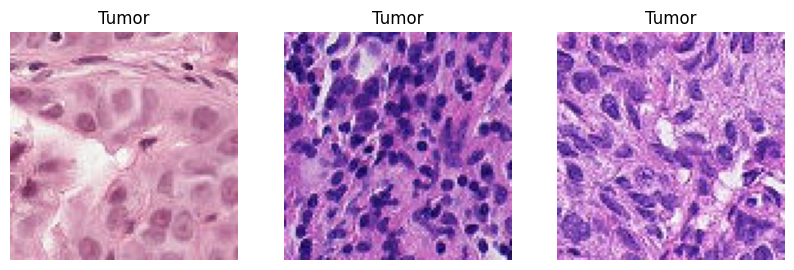

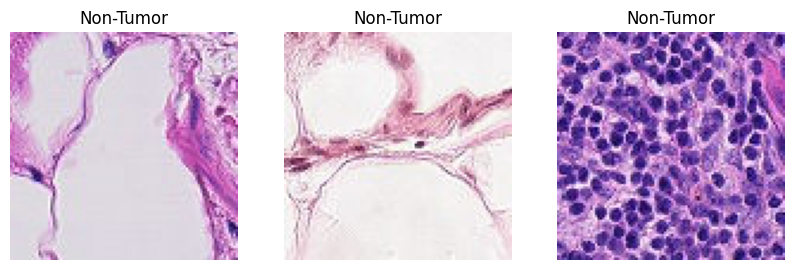

In [6]:
sample_tumor_ids = train_data[train_data['label'] == 1]['id'].sample(n=3).values
sample_normal_ids = train_data[train_data['label'] == 0]['id'].sample(n=3).values

tumor_images = []
for id in sample_tumor_ids:
    image_path = os.path.join(train_path, id + '.tif')  
    tumor_images.append(Image.open(image_path))
    
normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_path, id + '.tif') 
    normal_images.append(Image.open(image_path))
    
plt.figure(figsize=(10, 3))
for i, image in enumerate(tumor_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Non-Tumor')
    plt.axis('off')
plt.show()

In [7]:
counts = train_data['label'].value_counts().reset_index()
counts.columns = ['Label', 'Frequency']
counts['Label'] = counts['Label'].map({0:'Non-Tumor', 1:'Tumor'})
counts['Percentage'] = (counts['Frequency'] / counts['Frequency'].sum()) * 100
plt.figure(figsize=(10, 5))
bar_plot = sns.barplot(data=counts, x='Frequency', y='Label', palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Frequency')
plt.ylabel('Label')
for index, row in counts.iterrows():
    bar_plot.text(row['Frequency'], index, f"{row['Percentage']:.1f}%", va='center')

plt.show()

Apply some data transformations to fit into tf model expected input.

In [8]:
train_data["id"] = train_data["id"] + ".tif"
train_data["label"] = train_data["label"].astype(str)
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


The rgb values are scaled to 0-1 by dividing by 255, then the train data is split into 80% training and 20% validation. A 256 batch size is chosen optimizing for lower runtime and will be tweaked later based on performance.

In [9]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=28,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.


In [10]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=28,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 44005 validated image filenames belonging to 2 classes.


# Model Architecture

### **Model 1: Baseline Model**

Input Layer: The input shape specified for the model is (64, 64, 3), which corresponds to 64x64 pixel images with 3 color channels (RGB).

1. First Convolutional Block:

- Conv2D Layer: Applies 16 filters with a kernel size of (3,3) to the input.
- Another Conv2D Layer: Another layer with 16 filters of size (3,3). 
- MaxPooling2D Layer: A pooling layer with a pool size of (2,2). 

2.  Second Convolutional Block:

- Conv2D Layer: Increases the filter count to 32, with a kernel size of (3,3).
- Another Conv2D Layer: Continues with 32 filters of size (3,3).
- MaxPooling2D Layer: A pooling layer with a pool size of (2,2).
- Flattening Layer: The Flatten layer is used to convert the final feature maps into a single long feature vector, which serves as input to the fully connected layers.


3. Fully Connected Layer:

- Dense Layer: A dense layer with a single neuron and sigmoid activation function. Where the output is the probability of the input being one class or the other.

- Loss Function: The model uses 'binary_crossentropy', suitable for binary classification problems.
- Metrics: It tracks 'accuracy' and the AUC (Area Under the Curve) for the ROC curve.


### **Model 2: Enhanced Model**

This model includes several enhancements for better performance and generalization:

Input Layer: Similar to model1, the input shape for model2 is (64, 64, 3), suitable for 64x64 pixel RGB images.

1. First Convolutional Block:

- Conv2D Layer: Applies 16 filters of size (3,3).
- Activation Layer: Uses the ReLU (Rectified Linear Unit) activation function.
- Second Conv2D Layer: Another set of 16 filters of size (3,3).
- Batch Normalization: Normalizes the activations from the previous layer, which improves performance by reducing internal covariate shift.
- Activation Layer: Another ReLU activation.
- MaxPooling2D Layer: Reduces the spatial dimensions by half, similar to model1.
- Dropout (0.5): A dropout layer with a rate of 0.5, which randomly sets a fraction of input units to 0 at each update during training time, which helps in preventing overfitting.

2. Second Convolutional Block:

- Conv2D Layer: Increases to 32 filters, size (3,3).
- Activation Layer: ReLU activation.
- Second Conv2D Layer: Continues with 32 filters of size (3,3).
- Batch Normalization: Normalizes the activations from the previous layer.
- Activation Layer: ReLU activation again.
- MaxPooling2D Layer: Spatial reduction continues.
- Dropout (0.5): Another dropout layer, maintaining the strategy to combat overfitting.
- Flatten Layer: Converts the 3D feature maps to a 1D feature vector.

3. Fully Connected Layer:
- Dense Layer: A dense layer with a sigmoid activation function for binary classification output.

4. Compilation:

- Optimizer: Uses Stochastic Gradient Descent (SGD) with a learning rate of 0.01. This is a change from model1, which did not specify the optimizer explicitly (defaulting to Adam). SGD is a more traditional choice that sometimes offers more control and better generalization in practice.
- Loss Function: Uses 'binary_crossentropy' for binary classification.
- Metrics: Tracks 'accuracy' and AUC (Area Under the ROC Curve), as in model1.

**Note: 5 epochs will be standardised across all models due to the GPU limit.**

# Results and Analysis

In [11]:
model1_ROC = tf.keras.metrics.AUC()

model1 = Sequential()
    
model1.add(Conv2D(filters=16, kernel_size=(3,3)))
model1.add(Conv2D(filters=16, kernel_size=(3,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3)))
model1.add(Conv2D(filters=32, kernel_size=(3,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))
    
model1.build(input_shape=(32, 64, 64, 3))
    
model1.compile(loss='binary_crossentropy', metrics=['accuracy', model1_ROC])
    
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 62, 62, 16)          448       
                                                                 
 conv2d_1 (Conv2D)           (32, 60, 60, 16)          2320      
                                                                 
 max_pooling2d (MaxPooling2  (32, 30, 30, 16)          0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (32, 28, 28, 32)          4640      
                                                                 
 conv2d_3 (Conv2D)           (32, 26, 26, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 13, 13, 32)          0         
 g2D)                                                   

2024-06-06 21:47:39.261264: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-06-06 21:47:39.261394: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-06-06 21:47:39.261476: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-06-06 21:47:39.261550: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-06-06 21:47:39.261628: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-06-06 21:47:39.261827: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-06-06 21:47:39.261910: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [12]:
his_model1 = model1.fit(
                        train_generator,
                        steps_per_epoch=687,
                        epochs = 5,
                        validation_data = valid_generator,
                        validation_steps=171,
                        verbose=1)

Epoch 1/5
687/687 [==============================] - 1536s 2s/step - loss: 0.5962 - accuracy: 0.6933 - auc: 0.7398 - val_loss: 0.5260 - val_accuracy: 0.7592 - val_auc: 0.8362
Epoch 2/5
687/687 [==============================] - 468s 681ms/step - loss: 0.4970 - accuracy: 0.7660 - auc: 0.8321 - val_loss: 0.4569 - val_accuracy: 0.7925 - val_auc: 0.8660
Epoch 3/5
687/687 [==============================] - 505s 735ms/step - loss: 0.4659 - accuracy: 0.7865 - auc: 0.8544 - val_loss: 0.4334 - val_accuracy: 0.8069 - val_auc: 0.8755
Epoch 4/5
687/687 [==============================] - 372s 542ms/step - loss: 0.4521 - accuracy: 0.7937 - auc: 0.8636 - val_loss: 0.4520 - val_accuracy: 0.7944 - val_auc: 0.8704
Epoch 5/5
687/687 [==============================] - 366s 533ms/step - loss: 0.4403 - accuracy: 0.8013 - auc: 0.8711 - val_loss: 0.4449 - val_accuracy: 0.8027 - val_auc: 0.8787


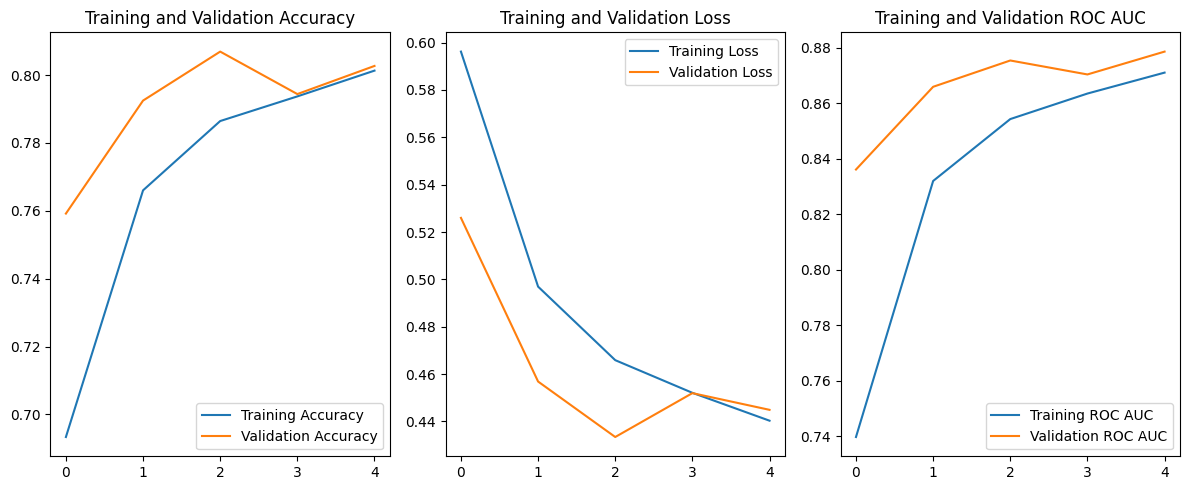

In [13]:
acc = his_model1.history['accuracy']
val_acc = his_model1.history['val_accuracy']
loss = his_model1.history['loss']
val_loss = his_model1.history['val_loss']
roc_auc = his_model1.history['auc']
val_roc_auc = his_model1.history['val_auc']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, roc_auc, label='Training ROC AUC')
plt.plot(epochs, val_roc_auc, label='Validation ROC AUC')
plt.title('Training and Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()


**Model 1 Results**

Interestingly enough, the validation curves showed better results than the training ones indicating there is not a lot of overfitting. Right around the fifth epoch, there is starting to show the two curves crossing and also the improvement between epochs starts to decrease.

Surprisingly, this simple model with no activation functions provides over 80% accuracy, and 86% ROC AUC which showcases the power of convolutional neural networks for solving this kind of binary classification problems.



# Model 2

In [14]:
model2_ROC = tf.keras.metrics.AUC()

model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(Activation("relu"))
model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(Activation("relu"))
model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(1, activation = "sigmoid"))

model2.build(input_shape=(32, 64, 64, 3))

model2.compile(SGD(learning_rate = 0.01), loss = "binary_crossentropy", metrics=['accuracy', model2_ROC])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (32, 62, 62, 16)          448       
                                                                 
 activation (Activation)     (32, 62, 62, 16)          0         
                                                                 
 conv2d_5 (Conv2D)           (32, 60, 60, 16)          2320      
                                                                 
 batch_normalization (Batch  (32, 60, 60, 16)          64        
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (32, 60, 60, 16)          0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 30, 30, 16)          0         
 g2D)                                                 

In [15]:
his_model2 = model2.fit(
                        train_generator, 
                        steps_per_epoch=687, 
                        epochs=5,
                        validation_data=valid_generator,
                        validation_steps=171,
                        verbose=1)

Epoch 1/5
687/687 [==============================] - 349s 507ms/step - loss: 0.6318 - accuracy: 0.7603 - auc_1: 0.8148 - val_loss: 0.6617 - val_accuracy: 0.7360 - val_auc_1: 0.8466
Epoch 2/5
687/687 [==============================] - 361s 526ms/step - loss: 0.4378 - accuracy: 0.8105 - auc_1: 0.8754 - val_loss: 0.4732 - val_accuracy: 0.7853 - val_auc_1: 0.8926
Epoch 3/5
687/687 [==============================] - 346s 504ms/step - loss: 0.4114 - accuracy: 0.8214 - auc_1: 0.8881 - val_loss: 0.4541 - val_accuracy: 0.7874 - val_auc_1: 0.8863
Epoch 4/5
687/687 [==============================] - 344s 501ms/step - loss: 0.3973 - accuracy: 0.8289 - auc_1: 0.8953 - val_loss: 0.5103 - val_accuracy: 0.7829 - val_auc_1: 0.8994
Epoch 5/5
687/687 [==============================] - 358s 522ms/step - loss: 0.3913 - accuracy: 0.8314 - auc_1: 0.8989 - val_loss: 0.3932 - val_accuracy: 0.8330 - val_auc_1: 0.8969


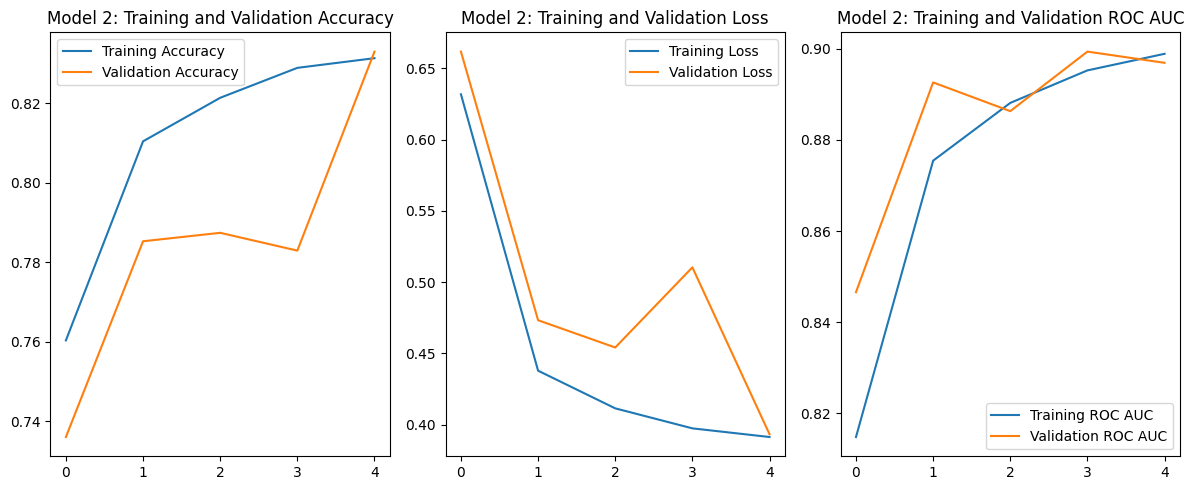

In [18]:
acc2 = his_model2.history['accuracy']
val_acc2 = his_model2.history['val_accuracy']
loss2 = his_model2.history['loss']
val_loss2 = his_model2.history['val_loss']
roc_auc2 = his_model2.history['auc_1']
val_roc_auc2 = his_model2.history['val_auc_1']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc2, label='Training Accuracy')
plt.plot(epochs, val_acc2, label='Validation Accuracy')
plt.title('Model 2: Training and Validation Accuracy')
plt.legend()

# loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss2, label='Training Loss')
plt.plot(epochs, val_loss2, label='Validation Loss')
plt.title('Model 2: Training and Validation Loss')
plt.legend()

# ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, roc_auc2, label='Training ROC AUC')
plt.plot(epochs, val_roc_auc2, label='Validation ROC AUC')
plt.title('Model 2: Training and Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

**Model 2 Results**

In this case, adding the activation function did cause a little bit of over-fitting, noticing how the training accuracy outperforms the validation one. The dropout did helped reducing the training duration to about 80%. Also, observe how after the last epoch the accuracy was maintained at around 80% but the ROC AUC increased up to 90%, indicating improvements on the model truly separating the two classes.

# Test Results

In [19]:
test_data = pd.DataFrame({'id':os.listdir(test_path)})
test_data.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [20]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [21]:
results = model2.predict(test_generator, verbose=1)

57458/57458 [==============================] - 351s 6ms/step


In [22]:
results = np.transpose(results)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, results))
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [23]:
submission_df.to_csv('submission.csv', index=False)

![Final Score](cnn_score.png)

## Results

With some few enhancements in model 2, a 0.81 Public score was achieved. 

What Helped Improve Model Performance:

Certainly, the best improvement came from the 0.5 dropout rate, reducing the training duration and cutting the gap between the training and validation curves.

What Did Not Help or Could Be Improved:

The number of epochs, with very long training durations it is very difficult to iterate through multiple model parameters, forcing the project to focus only in few epochs and only 2 models to compare and contrast.

Future Improvements to Explore:

Leveraging the GPU's and TPU's available at Kaggle's site to improve the training durations.

Github repo: https://github.com/luisdi28ms/deep_learning/tree/main/cnn